In [234]:
import errno
import requests
import os
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
import spotipy
from keras.optimizers import Adam
import spotipy.util as util
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
import sklearn
import numpy as np
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
token = util.oauth2.SpotifyClientCredentials(client_id="993643bfbd504d5aa303f13c71dfeb78", client_secret="d51eef4e56ec4db3899a62d9bb54cfa5")
cache_token = token.get_access_token()

In [ ]:
def get_artist(name):

    results = sp.search(q='artist:' + name, type='artist')

    items = results['artists']['items']

    if len(items) > 0:

        return items[0]

    else:

        return -1





def save_album_art(id, folder_name):

    albums = []

    results = sp.artist_albums(artist['id'], album_type='album')

    albums.extend(results['items'])

    while results['next']:

        results = sp.next(results)

        albums.extend(results['items'])

    print('Total albums:', len(albums))

    for album in albums:

        for images in album['images']:

            if images['height'] == 640:

                url = (images['url'])

                print(url)

                filename = "C:/Users/rohan/OneDrive/Desktop/ADM-Group-Project/" + folder_name  + "\\" + url.split('/')[

                    4] + ".jpeg"



                s = requests.Session()

                retries = Retry(total=5, backoff_factor=1, status_forcelist=[502, 503, 504])

                s.mount('http://', HTTPAdapter(max_retries=retries))

                album_art = s.get(url, allow_redirects=True)



                os.makedirs(os.path.dirname(filename), exist_ok=True)

                open(filename, 'wb').write(album_art.content)





def create_destination_folder(artist, genre):

    print('====', artist['name'], '====')

    print('Popularity: ', artist['popularity'])

    if len(artist['genres']) > 0:

        print('Genres: ', ','.join(artist['genres']))

    folder = "C:/Users/rohan/OneDrive/Desktop/ADM-Group-Project/genreFromAlbumCover/" + genre

    try:

        os.makedirs(folder)

    except OSError as e:

        if e.errno != errno.EEXIST:

            raise





if __name__ == '__main__':

    sp = spotipy.Spotify(cache_token)

    sp.trace = False



    with open("C:/Users/rohan/OneDrive/Desktop/ADM-Group-Project/metal1.txt", 'r') as f:

        names = [line.strip() for line in f]

        genre = "Metal"

    for name in names:

        artist = get_artist(name)

        if artist != -1:

            folder_name = create_destination_folder(artist, genre)

            save_album_art(artist, genre)

        else:

            print("No data for"+name)

In [170]:
from keras.preprocessing.image import ImageDataGenerator
train_datagenerator_1 = ImageDataGenerator(rescale=1./255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator1 = train_datagenerator_1.flow_from_directory(
    "C:/Users/rohan/OneDrive/Desktop/ADM-Group-Project/Final_Dir/",
    target_size=(64, 64),
    color_mode="rgb",
    batch_size=200,
    class_mode='categorical',
    subset = 'training') # set as training data

validation_generator1 = train_datagenerator_1.flow_from_directory(
    "C:/Users/rohan/OneDrive/Desktop/ADM-Group-Project/Final_Dir/", # same directory as training data
    target_size=(64, 64),
    batch_size=200,
    color_mode="rgb",
    class_mode='categorical',
    subset = 'validation') # set as validation data

Found 2090 images belonging to 4 classes.
Found 520 images belonging to 4 classes.


In [ ]:
# Convert class vectors to binary class matrices.
y_train_encoder = sklearn.preprocessing.LabelEncoder()
y_train_num = y_train_encoder.fit_transform(y_train)
y_train_wide = keras.utils.to_categorical(y_train_num, num_classes)

y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = keras.utils.to_categorical(y_test_num, num_classes)

In [127]:
#train_generator1.class_indices
X_train,y_train = train_generator1.next()

In [150]:
X_test,y_test = validation_generator1.next()

In [137]:
def create_model(optimizer="adam",dropout_rate=0.0):
    model_adm_spotify = Sequential()
    model_adm_spotify.add(Convolution2D(filters = 32, kernel_size = (3, 3),input_shape = (64, 64, 3),activation = "relu"))
    model_adm_spotify.add(MaxPooling2D(pool_size = (2, 2)))
    model_adm_spotify.add(Convolution2D(32, 3, 3, activation = "relu"))
    model_adm_spotify.add(MaxPooling2D(pool_size = (2, 2)))
    model_adm_spotify.add(Flatten())
    model_adm_spotify.add(Dense(units = 128, activation = "relu"))
    model_adm_spotify.add(Dropout(dropout_rate))
    model_adm_spotify.add(Dense(4))
    model_adm_spotify.add(Dense(units = 4, activation = "softmax"))
    model_adm_spotify.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics = ["accuracy"])
    return model_adm_spotify;

In [138]:
model_adm = KerasClassifier(build_fn=create_model) 

In [139]:
#Random Search
bsize = [20,30,40]
epoch = [5,10,15]
dropout_rate_1 = [0.0,0.2,0.4,0.6, 0.8]
opt=['SGD', 'Adam', 'Adamax', 'Nadam']
param_grid2 = dict(batch_size=batch_size, epochs=epochs,optimizer=opt,dropout_rate=dropout_rate)

nitersearch = 10 
random_search = RandomizedSearchCV(estimator=model_adm, 
                                   param_distributions=param_grid2,
                                   n_iter=nitersearch,
                                   n_jobs=-1)
random_search_result=random_search.fit(X_train, y_train)
# Show the results
print("Best Reported Accuracy: %f using parameters %s" % (random_search.best_score_, random_search.best_params_))
mean_score = random_search_result.cv_results_['mean_test_score']
std_score = random_search_result.cv_results_['std_test_score']
param_random_search = random_search_result.cv_results_['params']
for mean, stdev, param in zip(mean_score, std_score, param_random_search):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\rohan\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\rohan\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\rohan\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  """


Epoch 1/5
100/100 [==============================] - 2s 16ms/step - loss: 0.6668 - acc: 0.7025
Epoch 2/5
100/100 [==============================] - 0s 2ms/step - loss: 0.5597 - acc: 0.7425
Epoch 3/5
100/100 [==============================] - 0s 3ms/step - loss: 0.5389 - acc: 0.7500A: 0s - loss: 0.5470 - acc: 0.750
Epoch 4/5
100/100 [==============================] - 0s 3ms/step - loss: 0.5855 - acc: 0.7225
Epoch 5/5
100/100 [==============================] - 0s 2ms/step - loss: 0.5070 - acc: 0.7525
Best Reported Accuracy: 0.752500 using parameters {'optimizer': 'Nadam', 'epochs': 5, 'dropout_rate': 0.2, 'batch_size': 40}
0.750000 (0.000000) with: {'optimizer': 'Adamax', 'epochs': 10, 'dropout_rate': 0.8, 'batch_size': 20}
0.737500 (0.009367) with: {'optimizer': 'Adamax', 'epochs': 15, 'dropout_rate': 0.2, 'batch_size': 40}
0.737500 (0.014249) with: {'optimizer': 'Adamax', 'epochs': 15, 'dropout_rate': 0.4, 'batch_size': 20}
0.752500 (0.003483) with: {'optimizer': 'Nadam', 'epochs': 5, 

In [223]:
#Grid Search
bsize = [20,30,40]
epoch = [5,10]
dropout_rate_2 = [0.0,0.2,0.4,0.6, 0.8]
optim=['SGD', 'Adam', 'Adamax', 'Nadam']
param_grid1 = dict(batch_size=bsize, epochs=epoch,optimizer=optim,dropout_rate=dropout_rate_2)
grid = GridSearchCV(estimator=model_adm, param_grid=param_grid1, n_jobs=-1)
grid_search_result = grid.fit(X_train, y_train)
# summarize results
print("Best Reported Accuracy: %f using parameters %s" % (grid_search_result.best_score_, grid_search_result.best_params_))
mean_score1 = grid_search_result.cv_results_['mean_test_score']
std_score1 = grid_search_result.cv_results_['std_test_score']
param_grid_search = grid_search_result.cv_results_['params']
for mean, stdev, param in zip(mean_score1, std_score1, param_grid_search):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\rohan\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\rohan\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  """


Epoch 1/10
100/100 [==============================] - 2s 15ms/step - loss: 0.6457 - acc: 0.7075
Epoch 2/10
100/100 [==============================] - 0s 3ms/step - loss: 0.5768 - acc: 0.7350
Epoch 3/10
100/100 [==============================] - 0s 2ms/step - loss: 0.5368 - acc: 0.7500
Epoch 4/10
100/100 [==============================] - 0s 3ms/step - loss: 0.5553 - acc: 0.7475
Epoch 5/10
100/100 [==============================] - 0s 3ms/step - loss: 0.4915 - acc: 0.7650
Epoch 6/10
100/100 [==============================] - 0s 3ms/step - loss: 0.4650 - acc: 0.7875
Epoch 7/10
100/100 [==============================] - 0s 3ms/step - loss: 0.3908 - acc: 0.8225
Epoch 8/10
100/100 [==============================] - 0s 3ms/step - loss: 0.7088 - acc: 0.7500
Epoch 9/10
100/100 [==============================] - 0s 3ms/step - loss: 0.4059 - acc: 0.8100
Epoch 10/10
100/100 [==============================] - 0s 3ms/step - loss: 0.3319 - acc: 0.8625
Best Reported Accuracy: 0.755000 using parameter

In [153]:
model_adm_1 = Sequential()
model_adm_1.add(Convolution2D(filters = 32, kernel_size = (3, 3),input_shape = (64, 64, 3),activation = "relu"))
model_adm_1.add(MaxPooling2D(pool_size = (2, 2)))
model_adm_1.add(Convolution2D(32, 3, 3, activation = "relu"))
model_adm_1.add(MaxPooling2D(pool_size = (2, 2)))
model_adm_1.add(Flatten())
model_adm_1.add(Dense(units = 128, activation = "relu"))
model_adm_1.add(Dropout(0.2))
model_adm_1.add(Dense(4))
model_adm_1.add(Dense(units = 4, activation = "softmax"))
model_adm_1.compile(optimizer = 'Nadam', loss = "binary_crossentropy", metrics = ["accuracy"])

C:\Users\rohan\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  after removing the cwd from sys.path.


In [203]:
adm=model_adm_1.fit_generator(train_generator1, steps_per_epoch= train_generator1.samples/train_generator1.batch_size, epochs = 10, validation_data = validation_generator1, validation_steps=validation_generator1.samples/validation_generator1.batch_size,verbose=1)

Epoch 1/10
11/10 [===============================] - 12s 1s/step - loss: 0.5516 - acc: 0.7499 - val_loss: 0.5490 - val_acc: 0.7500
Epoch 2/10
11/10 [===============================] - 11s 997ms/step - loss: 0.5478 - acc: 0.7482 - val_loss: 0.5659 - val_acc: 0.7514
Epoch 3/10
11/10 [===============================] - 11s 998ms/step - loss: 0.5444 - acc: 0.7507 - val_loss: 0.5458 - val_acc: 0.7457
Epoch 4/10
11/10 [===============================] - 11s 992ms/step - loss: 0.5353 - acc: 0.7517 - val_loss: 0.5426 - val_acc: 0.7524
Epoch 5/10
11/10 [===============================] - 11s 993ms/step - loss: 0.5333 - acc: 0.7538 - val_loss: 0.5381 - val_acc: 0.7529
Epoch 6/10
11/10 [===============================] - 11s 1s/step - loss: 0.5214 - acc: 0.7566 - val_loss: 0.5326 - val_acc: 0.7538
Epoch 7/10
11/10 [===============================] - 11s 997ms/step - loss: 0.5109 - acc: 0.7615 - val_loss: 0.5270 - val_acc: 0.7649
Epoch 8/10
11/10 [===============================] - 11s 1s/step - l

In [236]:
model_adm_2 = Sequential()
model_adm_2.add(Convolution2D(filters = 32, kernel_size = (3, 3),input_shape = (64, 64, 3),activation = "relu"))
model_adm_2.add(MaxPooling2D(pool_size = (2, 2)))
model_adm_2.add(Convolution2D(32, 3, 3, activation = "relu"))
model_adm_2.add(MaxPooling2D(pool_size = (2, 2)))
model_adm_2.add(Flatten())
model_adm_2.add(Dense(units = 128, activation = "relu"))
model_adm_2.add(Dropout(0.2))
model_adm_2.add(Dense(4))
model_adm_2.add(Dense(units = 4, activation = "softmax"))
model_adm_2.compile(optimizer = Adam(lr=0.01), loss = "binary_crossentropy", metrics = ["accuracy"])

C:\Users\rohan\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  after removing the cwd from sys.path.


In [237]:
adm_1=model_adm_2.fit_generator(train_generator1, steps_per_epoch= train_generator1.samples/train_generator1.batch_size, epochs = 10, validation_data = validation_generator1, validation_steps=validation_generator1.samples/validation_generator1.batch_size,verbose=1)

Epoch 1/10
11/10 [===============================] - 45s 4s/step - loss: 1.5313 - acc: 0.7097 - val_loss: 0.5593 - val_acc: 0.7500
Epoch 2/10
11/10 [===============================] - 32s 3s/step - loss: 0.5581 - acc: 0.7500 - val_loss: 0.5532 - val_acc: 0.7500
Epoch 3/10
11/10 [===============================] - 28s 3s/step - loss: 0.5530 - acc: 0.7500 - val_loss: 0.5564 - val_acc: 0.7500
Epoch 4/10
11/10 [===============================] - 29s 3s/step - loss: 0.5542 - acc: 0.7500 - val_loss: 0.5529 - val_acc: 0.7500
Epoch 5/10
11/10 [===============================] - 28s 3s/step - loss: 0.5544 - acc: 0.7500 - val_loss: 0.5557 - val_acc: 0.7500
Epoch 6/10
11/10 [===============================] - 28s 3s/step - loss: 0.5541 - acc: 0.7500 - val_loss: 0.5522 - val_acc: 0.7500
Epoch 7/10
11/10 [===============================] - 28s 3s/step - loss: 0.5524 - acc: 0.7500 - val_loss: 0.5541 - val_acc: 0.7500
Epoch 8/10
11/10 [===============================] - 29s 3s/step - loss: 0.5559 - a

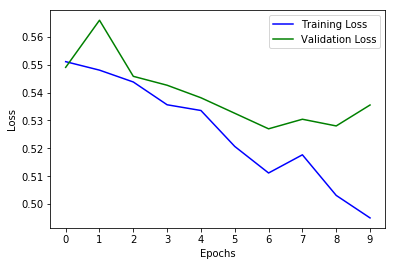

In [224]:
loss = adm.history['loss']
val_loss = adm.history['val_loss']
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,10)[0::1])
plt.legend()
plt.show()

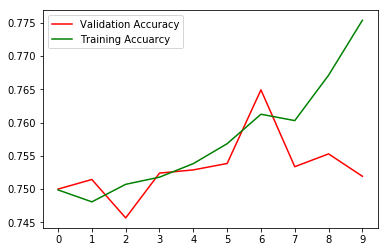

In [229]:
val_acc=adm.history['val_acc']
acc=adm.history['acc']
plt.plot(val_acc, 'red', label='Validation Accuracy')
plt.plot(acc, 'green', label='Training Accuarcy')
plt.xticks(range(0,10)[0::1])
plt.legend()
plt.show()

In [225]:
print(adm.history)

{'val_loss': [0.549020148240603, 0.5659166482778696, 0.5458065133828384, 0.5426101913818946, 0.5381171107292175, 0.5325558139727666, 0.5269806339190557, 0.5304160576600295, 0.5280150816990778, 0.5355212688446045], 'val_acc': [0.75, 0.7514423177792475, 0.7456730741720933, 0.7524038553237915, 0.7528846126336318, 0.7538461501781757, 0.7649038388178899, 0.7533653882833627, 0.7552884679574233, 0.7519230750890878], 'loss': [0.5510644847126098, 0.5480246355659083, 0.5437744550727771, 0.5356049452101785, 0.5335493769371908, 0.5206636315897891, 0.5111398252003501, 0.5176598817537846, 0.5031034994923897, 0.495029917031384], 'acc': [0.7498803800372986, 0.7480861262271279, 0.7507177026648271, 0.751794270921552, 0.7538277495420721, 0.7568181858678754, 0.7612440141194174, 0.7602870866442412, 0.7671052631008568, 0.7753588434611781]}


In [207]:
steps_spotify = np.math.ceil( validation_generator1.samples/validation_generator1.batch_size)
predictions = model_adm_1.predict_generator(validation_generator1,steps=steps_spotify)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

In [208]:
print(predicted_classes)

[0 2 0 0 0 1 0 0 0 3 0 0 2 1 2 0 0 2 2 0 2 2 0 0 0 2 0 0 2 0 0 2 2 0 2 2 2
 2 0 0 0 0 2 0 0 0 3 0 2 0 0 3 2 3 2 3 0 0 0 2 2 0 0 0 0 0 3 0 0 3 2 0 0 3
 2 2 1 0 2 1 2 0 0 0 0 0 2 2 2 0 2 2 2 1 0 0 0 3 0 2 2 2 0 0 2 2 0 0 0 2 0
 0 2 1 0 0 0 0 0 0 0 2 2 2 3 1 0 0 0 3 2 2 3 2 0 0 0 0 2 2 3 2 2 2 3 0 3 0
 0 0 0 2 0 0 2 0 0 0 2 0 0 0 2 0 0 1 1 2 2 0 0 3 0 2 0 2 0 0 0 3 0 0 0 2 0
 0 0 0 0 2 0 2 0 3 2 2 0 0 2 3 2 0 0 0 2 3 0 0 0 0 2 0 0 0 2 2 0 0 0 0 0 2
 2 0 2 3 0 0 2 0 3 0 0 0 0 0 0 0 2 0 0 0 2 0 2 0 2 0 0 0 0 0 0 1 0 0 0 0 2
 0 2 0 0 0 2 2 2 2 0 0 0 0 0 2 0 0 3 0 1 0 0 3 2 2 3 0 2 0 1 0 0 0 2 2 2 0
 1 0 0 0 3 2 0 0 2 2 1 0 0 0 0 0 0 0 0 0 1 0 2 3 2 1 0 0 3 3 3 2 0 0 0 2 2
 3 2 2 2 2 0 2 0 2 2 3 0 0 0 0 0 2 0 2 3 2 3 0 0 1 0 0 0 2 2 2 0 0 2 0 1 2
 0 0 0 1 0 1 0 2 0 2 3 0 2 0 2 0 0 2 2 0 0 0 2 0 2 0 3 2 0 0 0 0 0 2 0 2 0
 0 2 0 0 2 1 0 2 2 2 3 0 2 0 0 2 3 2 0 0 0 1 2 1 2 1 0 3 0 2 2 0 0 0 0 0 2
 0 0 0 0 2 2 0 2 2 0 3 0 2 0 0 2 0 2 2 0 3 0 2 0 0 0 3 0 2 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 2 0 0 2 2 0 

In [209]:
true_classes = validation_generator1.classes
class_labels = list(validation_generator1.class_indices.keys())

In [191]:
print(validation_generator1.class_indices)

{'Country': 0, 'Metal': 1, 'Rap': 2, 'Trance': 3}


In [210]:
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)
print(metrics.confusion_matrix(true_classes, predicted_classes))

              precision    recall  f1-score   support

     Country       0.33      0.54      0.41       181
       Metal       0.07      0.02      0.03       103
         Rap       0.25      0.31      0.28       126
      Trance       0.16      0.06      0.09       110

   micro avg       0.28      0.28      0.28       520
   macro avg       0.20      0.23      0.20       520
weighted avg       0.22      0.28      0.23       520

[[97  9 58 17]
 [66  2 28  7]
 [66  9 39 12]
 [65  8 30  7]]
